## Preface



If need be&#x2026;



In [1]:
#!pip install -r requirements.txt

## Introduction



Here we give a set of generic instructions for analyzing demand for
food and nutrition.  Inputs include a datasets of consumption
quantities, consumption expenditures, household characteristics, and a
food conversion table.

The different datasets should be indexed as follows:


| Dataset|Indexed by|Columns|
|---|---|---|
| Expenditures|i,t,m|j|
| Consumption|i,t,m,u|j|
| Prices|j,u|t,m|
| HH Characteristics|i,t,m|k|
| FCT|j,u|n|
| RDI|n|k|

where `i` indexes households, `t` indexes periods, `m` indexes
markets, `j` indexes goods, `k` indexes different kinds of household
characteristics, `u` indexes different unit names, and `n` indexes
different nutrients.  Finally, any RDI (&ldquo;recommended daily intake&rdquo;)
tables should be indexed by nutrients, with columns corresponding to
characteristics of persons within the household (e.g., age & sex
categories).

Note that some countries have more than one dataframe of consumption,
distinguished by source; for example Malawi has consumption items
purchased as well as consumption items produced.  Here we focus on
consumption purchases, since one of our immediate aims is to infer
prices paid.



## Step 1: Acquire DataFrames



Here are addresses of google sheets for different dataframes for the
case of Uganda:



In [57]:
#Guatemala
InputFiles = {'Expenditures':('1x6A8fRQXzrdhzOV2UZTxzqhFfA-pt7T_sTmMNcQu_VQ','Food Expenditures'),
              'Prices':('1x6A8fRQXzrdhzOV2UZTxzqhFfA-pt7T_sTmMNcQu_VQ','Transposed'),
              'HH Characteristics':('1x6A8fRQXzrdhzOV2UZTxzqhFfA-pt7T_sTmMNcQu_VQ','Household Characteristics'),
              'FCT':('1x6A8fRQXzrdhzOV2UZTxzqhFfA-pt7T_sTmMNcQu_VQ','FCT'),
              'RDI':('1x6A8fRQXzrdhzOV2UZTxzqhFfA-pt7T_sTmMNcQu_VQ','RDI'),}

Note that in some cases not the food items for the FCT (e.g., for Niger) are **not** yet all matched up (&ldquo;harmonized&rdquo;) with food labels indexed by `j` in the expenditure,
consumption and price datasets.



In [58]:
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd

def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures...
x = get_clean_sheet(InputFiles['Expenditures'][0],
                    sheet=InputFiles['Expenditures'][1])

if 'm' not in x.columns:
    x['m'] = 1

x = x.set_index(['i','t','m'])
x.columns.name = 'j'

x = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))
x = x.replace(0,np.nan)

# Get HH characteristics...
z = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in z.columns:
    z['m'] = 1

z = z.set_index(['i','t','m'])
z.columns.name = 'k'

z = z.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Get prices
p = get_clean_sheet(InputFiles['Prices'][0],
                    sheet=InputFiles['Prices'][1])

if 'm' not in p.columns:  # Supply "market" indicator if missing
    p['m'] = 1

p = p.set_index(['t','m'])
p.columns.name = 'j'

p = p.apply(lambda x: pd.to_numeric(x,errors='coerce'))
p = p.replace(0,np.nan)

fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

#### This bit peculiar to Niger FCT #####
#fct = fct.loc[fct.Code.str.len()==6]
#fct = fct.set_index('Code')
#fct.columns = [v.replace('\n',' ') for v in fct.columns]
########################################
fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

################## RDI, if available (consider using US) #####################
rdi = get_clean_sheet(InputFiles['RDI'][0],
                    sheet=InputFiles['RDI'][1])
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

## Step 2: Estimate Demand System



Here, use data on log *expenditures* and household characteristics to
create a CFEDemand `Regression` result.



In [59]:
import cfe

result = cfe.Regression(y=np.log(x.stack()),d=z)

result.get_beta().sort_values(ascending=False) # Check sanity...

j
Ice Cream          1.739132
Juice (Branded)    1.721491
Bananas            1.667667
Milk               1.578322
Candies            1.555973
                     ...   
Other Sauces       0.644436
Beans              0.584281
Salt               0.554703
Tortillas          0.434879
Maize              0.013067
Name: beta, Length: 76, dtype: float64

Make this persistent&#x2026;



In [60]:
result.to_pickle('./foo.pickle')

## Step 3: Infer quantities



Next, we divide predicted expenditures by prices to get
quantities (in kilograms) we can map into the  FCT.



In [61]:
import cfe

result = cfe.read_pickle('foo.pickle')  # Get persistent result saved above...

xhat = result.predicted_expenditures()

# Expenditures divided by prices/kg gives quantities in kgs...
qhat = (xhat.unstack('j')/p).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

Note that `qhat` may give prices for different *units*.  If prices
differ **only** because of units (e.g., one deciliter costs one
tenth as much as a liter), then we can use these differences in prices
to convert between different units, even if the units (e.g., &ldquo;basket&rdquo;)
is otherwise unclear.  

If we have enough data on purchases in kilograms, just keep those
prices (otherwise choose some other useful unit).  We also assume
prices are the same for everyone, so just take median.



## Step 4: Map predicted quantities into nutrients



Before this will work, need columns of qhat to match columns of fct.



In [62]:
use = fct.index.intersection(qhat.columns)


nutrients = qhat[use]@fct.loc[use,:]
nutrients.mean()    # NB: Nutrients are for past /week/ for entire household. (Depends on dataset)

n
Water (hg)                    2803.305800
Water                        28033.058003
Energy (hg)                  11436.894537
Energy                      114368.945373
Protein (hg)                   305.932664
Protein                       3059.326644
Total Fat                      136.278470
Carbohydrate (hg)             2427.947102
Carbohydrate                 24279.471020
Fiber (hg)                            NaN
Fiber                          141.938655
Folate                          64.312768
Calcium (hg)                  5669.144030
Calcium                      56691.440300
Phosphorus (hg)                       NaN
Phosphorus                   90401.367527
Iron (hg)                      217.033070
Iron                          2170.330697
Thiamin (hg)                     8.725708
Thiamin                         87.257080
Riboﬂavin                       86.700537
Riboﬂavin hg                     8.670054
Niacin                        1300.426540
Niacin (hg)                    1

## Household Nutritional Adequacy



Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For each household, we know the numbers of people in different age-sex categories.  We can match these up with data from an RDI (Recommended Dietary Intakes), then sum over different types.



In [63]:
z = z[rdi.columns.tolist()]

hh_rdi = z@rdi.T

# Uganda data is per week, so make this a recommended WEEKLY intake:
hh_rwi = hh_rdi*7
hh_rwi

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Magnesium,Niacin,Phosphorus,Potassium,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Vitamin E,Vitamin K,Zinc
i,t,m,,,,,,,,,,,,,,,,,,,,
1,2000,Metropolitana,50400.0,1127.0,705.6,9450.0,25900.0,3640.0,357.0,7770.0,350.0,17920.0,119700.0,28.0,27.3,18200.0,56.7,30.8,1785.0,357.0,2310.0,210.0
2,2000,Metropolitana,40600.0,1106.0,568.4,8400.0,22400.0,2730.0,168.0,8120.0,322.0,14700.0,98700.0,25.9,24.5,17500.0,50.4,31.5,1785.0,315.0,2310.0,210.0
3,2000,Metropolitana,84000.0,1974.0,1176.0,15400.0,46200.0,5460.0,406.0,14280.0,602.0,37100.0,194600.0,47.6,45.5,32200.0,92.4,53.2,3045.0,574.0,3990.0,399.0
4,2000,Metropolitana,11200.0,322.0,156.8,2800.0,8400.0,910.0,56.0,2240.0,98.0,4900.0,32900.0,7.7,7.7,4900.0,16.8,10.5,525.0,105.0,630.0,56.0
5,2000,Metropolitana,37800.0,847.0,529.2,7000.0,21000.0,2730.0,252.0,6090.0,266.0,13300.0,92400.0,21.0,20.3,14000.0,42.0,22.4,1330.0,259.0,1855.0,168.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7272,2000,Suroriente,11200.0,322.0,156.8,2800.0,8400.0,910.0,56.0,2240.0,98.0,4900.0,32900.0,7.7,7.7,4900.0,16.8,10.5,525.0,105.0,630.0,56.0
7273,2000,Suroriente,56000.0,1071.0,784.0,9450.0,32900.0,4550.0,371.0,7350.0,364.0,20020.0,140000.0,28.7,28.0,18900.0,56.7,30.1,1610.0,350.0,2450.0,224.0
7274,2000,Suroriente,81200.0,1736.0,1136.8,15050.0,53200.0,6370.0,518.0,12530.0,574.0,42770.0,209300.0,44.1,43.4,29400.0,90.3,48.3,2520.0,560.0,3430.0,364.0


Now, what proportion of `hh_rwi` do households consume?



In [64]:
# Match up nutrient names
use_nutrients = nutrients.columns.intersection(hh_rwi.columns)

nutrient_ratio = (nutrients[use_nutrients].fillna(0)/hh_rwi[use_nutrients]).dropna()

nutrient_ratio

,,n,Energy,Protein,Carbohydrate,Fiber,Folate,Calcium,Phosphorus,Iron,Thiamin,Niacin,Vitamin C,Vitamin A,Potassium,Zinc,Magnesium,Vitamin B-6,Vitamin B-12
i,t,m,,,,,,,,,,,,,,,,,
1,2000,Metropolitana,1.712667,2.052554,5.028132,0.155105,0.005256,1.650403,3.721219,4.719113,2.561711,2.966965,1.844303,1.883820,0.108779,1.585092,0.0,0.819659,1.623630
2,2000,Metropolitana,2.392710,2.333301,7.442732,0.246129,0.006700,2.129042,4.966639,11.247074,3.268120,3.677061,2.285763,2.313600,0.161367,1.893070,0.0,0.941300,2.215186
3,2000,Metropolitana,2.098590,2.377207,6.906588,0.176808,0.006471,1.886089,3.778462,8.289170,2.975505,3.369918,2.117537,1.883169,0.134524,1.447487,0.0,0.938126,1.857608
5,2000,Metropolitana,2.763013,3.288577,7.994431,0.311775,0.008850,2.420283,5.765953,8.282512,4.521995,5.097198,3.637572,3.415323,0.206433,2.725290,0.0,1.696454,3.269180
6,2000,Metropolitana,2.324709,2.737318,5.430151,0.215564,0.006412,1.694268,3.606881,5.899500,3.197653,3.690649,2.604599,2.468241,0.132558,2.131929,0.0,0.932618,1.912724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7271,2000,Suroriente,1.213966,1.751093,3.061358,0.094319,0.004046,0.981914,2.647512,3.413398,1.868419,2.124715,1.262925,1.310896,0.065680,1.084849,0.0,0.568200,1.080298
7272,2000,Suroriente,4.655834,4.340980,12.071165,0.463269,0.010969,3.056032,8.008277,18.469437,5.744504,6.707543,4.548796,4.608206,0.252808,3.895447,0.0,1.599218,3.687373
7273,2000,Suroriente,2.519202,3.603342,6.438027,0.293751,0.009013,2.110757,5.175868,7.595358,4.407632,5.060591,4.395744,3.508290,0.241198,2.980962,0.0,1.612424,2.857285


Graph ratios of adequacy for particular nutrients



<Axes: >

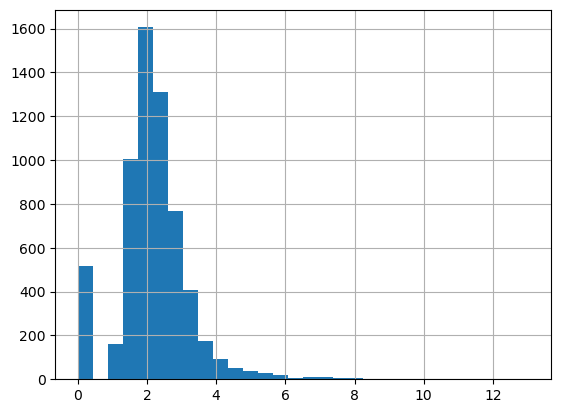

In [67]:
%matplotlib inline
nutrient_ratio['Protein'].hist(bins=30)

In [69]:
((nutrient_ratio['Energy']) < 1).mean()

0.09029454369869629